In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt


In [13]:

np.random.seed(42)
random.seed(42)
n_samples = 1000
df = pd.read_csv('sredjeni.csv')
X = df.drop(columns=["Cena"])
y = df["Cena"]  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def evaluate(model, X_val, y_val, name):
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    log_rmse = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(preds)))
    mape = mean_absolute_percentage_error(y_val, preds)
    metrics = {
        "RMSE": rmse,
        "log-RMSE": log_rmse,
        "MAPE": mape
    }

    plt.figure(figsize=(6, 4))
    plt.bar(metrics.keys(), metrics.values(), color=["skyblue", "lightgreen", "salmon"])
    plt.title(f"Evaluation Metrics - {name}")
    plt.ylabel("Value")
    plt.yscale('log')
    plt.show()
    print(f"{name} -> RMSE: {rmse:.2f}, log-RMSE: {log_rmse:.4f}, MAPE: {mape:.4f}")



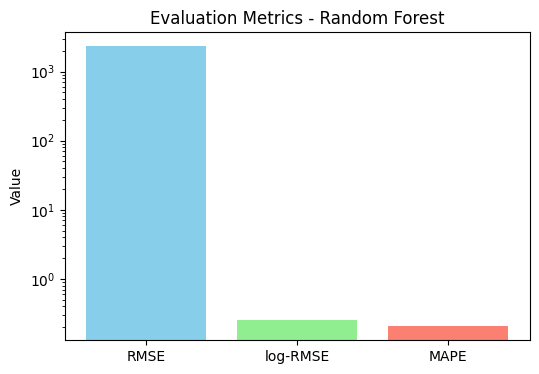

Random Forest -> RMSE: 2320.62, log-RMSE: 0.2565, MAPE: 0.2058


In [14]:
#najobicniji
rf = RandomForestRegressor(n_estimators=200, random_state=42) 
rf.fit(X_train, y_train)
evaluate(rf, X_val, y_val, "Random Forest")

Želimo da vidimo feature importance i da izbacimo ona obilježja čiji je feature importance mali.

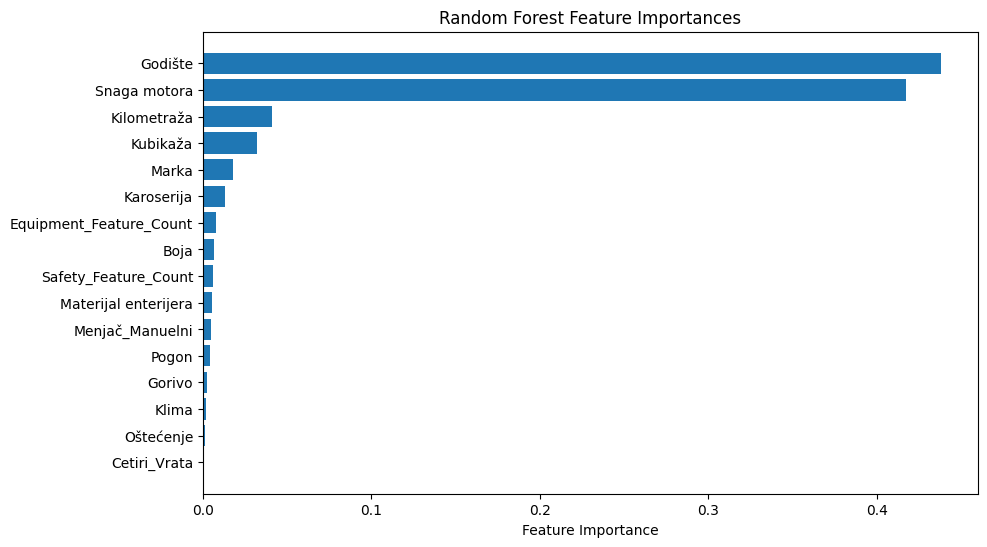

In [15]:

importances = rf.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
plt.gca().invert_yaxis()  # most important at the top
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

"Cetiri_Vrata", "Gorivo","Klima","Safety_Feature_Count","Materijal enterijera","Boja" su obeležja koja izbacujemo iz skupa

In [16]:
#probavamo da izbacimo parametre koji su slab importance, poboljsanje bude minimalno. Rezultati su sa i bez korekcije slicni
#rezultatima u radovima.
#pokusavamo sa izbacivanjem nekih koji imaju najmanji importance i izbacuju se jedan po jedan. p vrednosti za feature importance.

np.random.seed(42)
n_samples = 1000
df = pd.read_csv('sredjeni.csv')
X_rf = df.drop(columns=["Cena","Cetiri_Vrata", "Gorivo","Klima","Safety_Feature_Count","Materijal enterijera","Boja"])
y_rf = df["Cena"]  

X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.5, random_state=42)

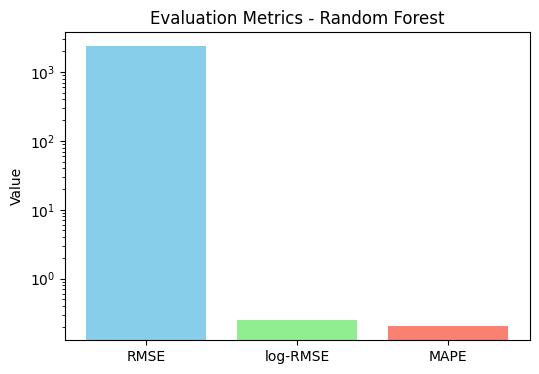

Random Forest -> RMSE: 2365.21, log-RMSE: 0.2517, MAPE: 0.2031


In [17]:
#najobicniji ali pokrenut nad manje parametara
rf = RandomForestRegressor(n_estimators=200, random_state=42) 
rf.fit(X_train_rf, y_train_rf)
evaluate(rf, X_val_rf, y_val_rf, "Random Forest")

In [ ]:
Tražimo najbolju kombinaciju hiperparametara pomoću randomized search, s tim da prosljeđujemo skup odataka gdje su izbačena obeležja koja
su imala mali feature importance.

Fitting 5 folds for each of 50 candidates, totalling 250 fits


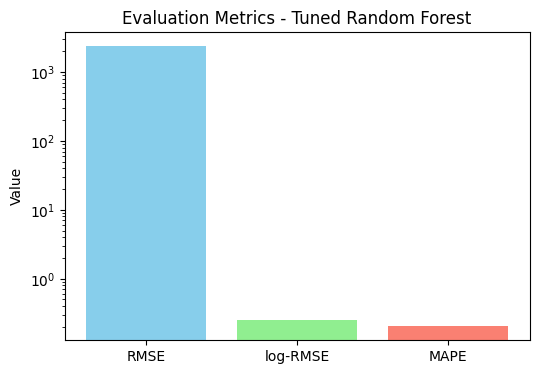

Tuned Random Forest -> RMSE: 2363.60, log-RMSE: 0.2516, MAPE: 0.2038
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30}


In [18]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_percentage_error', # Use MAPE as the scoring metric
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#unapredjeni rf koji trazi najbolji rezultat sa kombinacijamam parametara. koristimo samo odre]ene parametre -- ovdje smo dobili najbolji rezultat za rf

random_search.fit(X_train_rf, y_train_rf)

best_rf = random_search.best_estimator_
evaluate(best_rf, X_val_rf, y_val_rf, "Tuned Random Forest")
print(f"Best parameters: {random_search.best_params_}")

XGBoost. Prvo smo probali sa najobičnijim. Pa smo kao i za prethodni model, odradili randomized search i prikazali najbolje rezultate.

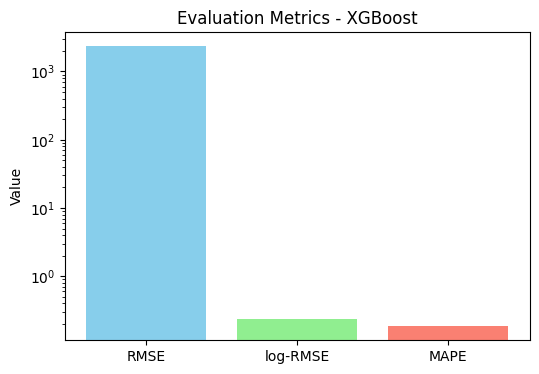

XGBoost -> RMSE: 2342.22, log-RMSE: 0.2321, MAPE: 0.1846
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30}


In [19]:
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
evaluate(xgb_model, X_val, y_val, "XGBoost")
print(f"Best parameters: {random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


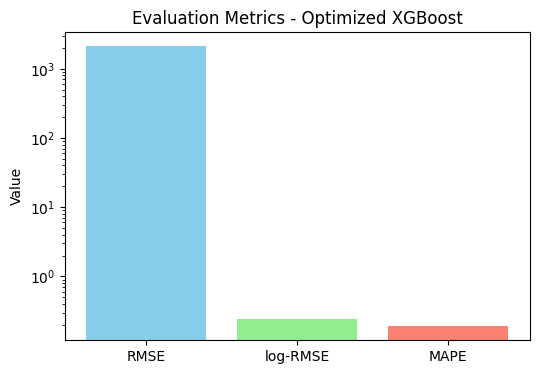

Optimized XGBoost -> RMSE: 2108.03, log-RMSE: 0.2388, MAPE: 0.1899
Best parameters: {'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [21]:
# optimiyacija  hiperparametara MAPE 0.17
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 4]
}

xgb_model = xgb.XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

best_xgb_model = random_search.best_estimator_

evaluate(best_xgb_model, X_val, y_val, "Optimized XGBoost")
print(f"Best parameters: {random_search.best_params_}")

Forward ANN sa randomized search

In [11]:
#ocekivali smo da ann ima gore rezultate, ali smo se prijatno iznenadili. Krenuli smo sa greskom MAPE 0.6, i dosli do 0.2
# np.random.seed(42)
# random.seed(42)
# tf.random.set_seed(42)
# model = keras.Sequential([
#     keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(1)
# ])


# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# preds = model.predict(X_val).flatten()
# rmse = np.sqrt(mean_squared_error(y_val, preds))
# log_rmse = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(preds)))
# mape = mean_absolute_percentage_error(y_val, preds)
# print(f"Feed-forward ANN -> RMSE: {rmse:.2f}, log-RMSE: {log_rmse:.4f}, MAPE: {mape:.4f}")

# #sumirati rezultate. najbolji algoritam pogledati gdje je pogrijesio ---- analiza gresaka da vidimo da li postoji neki sablon.

In [9]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# arhitektura nase mreze
def build_model(optimizer="adam", learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])
    if optimizer == "adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        opt = optimizer
    model.compile(optimizer=opt, loss="mse")
    return model

# model wrap za randomized search
keras_reg = KerasRegressor(
    model=build_model, 
    verbose=0,
    random_state=42
)


param_dist = {
    "model__optimizer": ["adam", "sgd"],
    "model__learning_rate": [0.001, 0.01],
    "batch_size": [16, 32, 64],
    "epochs": [50, 100]
}

# 
random_search = RandomizedSearchCV(
    estimator=keras_reg,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=0,
    n_jobs=1,  # Changed to 1 to avoid multiprocessing issues
    random_state=42,
    scoring="neg_mean_absolute_percentage_error"
)

# FIX: Remove validation_data - not compatible with cross-validation
random_search.fit(X_train, y_train)

# --- Get best model ---
best_ann = random_search.best_estimator_.model_


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


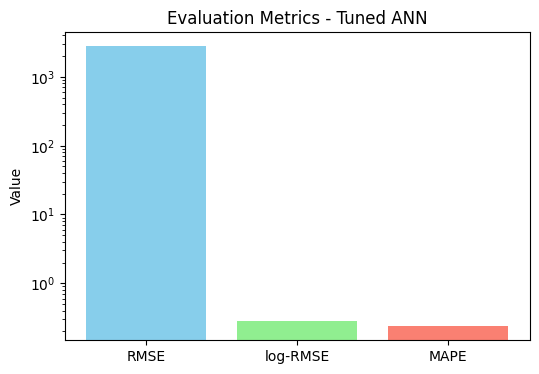

Tuned ANN -> RMSE: 2779.15, log-RMSE: 0.2813, MAPE: 0.2373

Best parameters: {'model__optimizer': 'adam', 'model__learning_rate': 0.01, 'epochs': 50, 'batch_size': 64}
Best CV score: 0.242408158420362


In [10]:
evaluate(best_ann, X_val, y_val, "Tuned ANN")
print("\nBest parameters:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)  # Negative because sklearn uses negative MAPE

Sumirani rezultati

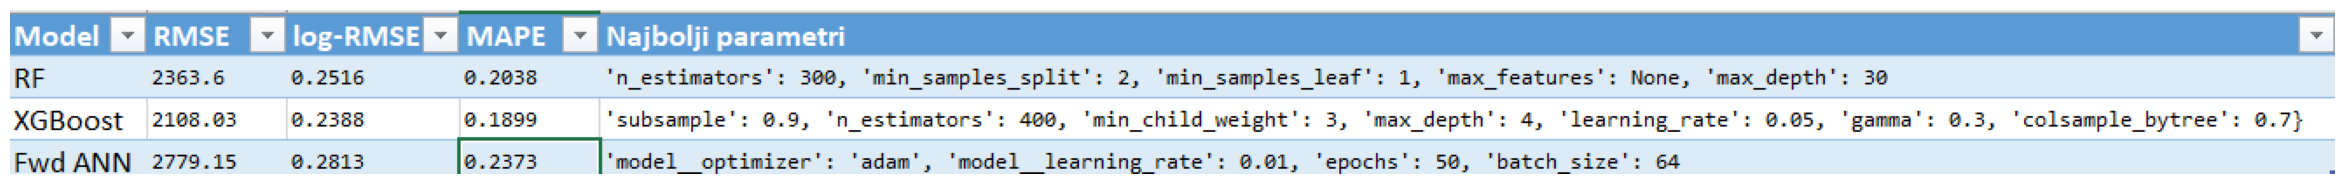

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("C:/Users/Laptop/Pictures/Screenshots/Screenshot 2025-09-29 220244.png")
plt.figure(figsize=(30, 15)) 
plt.imshow(img)
plt.axis("off")  # optional: hide axes
plt.show()